In [164]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from minisom import MiniSom

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [165]:
# load dataset
data_file_path = '/Users/asmakhimani/Downloads/systemic lupus_Dataset_Team_ML.csv'
data = pd.read_csv(data_file_path)

In [166]:
# preview dataset 
print(data.head())

        ID  Ancestry_African  Ancestry_Any other Asian background  \
0  5713894               0.0                                  0.0   
1  2048882               0.0                                  0.0   
2  1748132               0.0                                  0.0   
3  3772083               0.0                                  0.0   
4  4376107               0.0                                  0.0   

   Ancestry_Any other Black background  Ancestry_Any other mixed background  \
0                                  0.0                                  0.0   
1                                  0.0                                  0.0   
2                                  0.0                                  0.0   
3                                  0.0                                  0.0   
4                                  0.0                                  0.0   

   Ancestry_Any other white background  Ancestry_Asian or Asian British  \
0                                  

In [167]:
# filter for british ancestry 
data = data[data['Ancestry_British'] == 1]

In [168]:
# how many british ancestry patients
int(data['Ancestry_British'].sum())

442574

In [169]:
# drop nan values from data
data = data.dropna()

In [170]:
# rename columns 

column_renames = {
    'f.21022.0.0': 'Age',
    'f.21001.0.0': 'BMI',
    'f.31.0.0_Female': 'Female',
    'f.31.0.0_Male': 'Male',
    'f.20116.0.0_Current': 'Current Smoker',
    'f.20116.0.0_Previous': 'Former Smoker',
    'f.20116.0.0_Never': 'Never Smoker',
    'f.20116.0.0_Prefer not to answer': 'Unknown Smoking Status',
    'f.6145_Death of a close relative': 'Death of Family Member',
    'f.6145_Serious illness, injury or assault to yourself': 'Serious illness, injury or assault to yourself',
    'f.6145_Serious illness, injury or assault of a close relative': 'Serious illness, injury or assault of a close relative',
    'f.6145_Financial difficulties': 'Financial difficulties',
    'f.6145_Marital separation/divorce': 'Marital separation/divorce',
    'f.6145_Death of a spouse or partner': 'Death of a spouse or partner',
    'f.6145_None of the above': 'No Stress',
    'f.6145_Prefer not to answer': 'Unknown Stress Status',
    'f.1558.0.0_Daily or almost daily': 'Daily Alcohol Consumption',
    'f.1558.0.0_Never': 'No Alcohol Consumption',
    'f.1558.0.0_Once or twice a week': 'Once or Twice a Week Alcohol Consumption',
    'f.1558.0.0_One to three times a month': 'One to Three Times a Month Alcohol Consumption',
    'f.1558.0.0_Prefer not to answer': 'Unknown Alcohol Consumption',
    'f.1558.0.0_Special occasions only': 'Occasional Alcohol Consumption',
    'f.1558.0.0_Three or four times a week': 'Three or Four Times a week Alcohol Consumption',
    'f.904.0.0': 'Number of Days of Physical Activity',
    'f.904.0.0_Do not know': 'Not known Physical Activity Status',
    'f.904.0.0_Prefer not to answer': 'Not Answered Physical Activity Status',
    'f.20107_Father_Bowel cancer' : 'Father has Bowel Cancer',
    'f.20107_Father_Diabetes': 'Father has Diabetes',
    'f.20110_Mother_Bowel cancer': 'Mother has Bowel Cancer',
    'f.20110_Mother_Diabetes': 'Mother has Diabetes'
}

In [171]:
# only keep renamed columns in dataframe
columns_to_keep = column_renames.keys()
data = data[columns_to_keep]
data = data.rename(columns=column_renames)
print(data.head())

    Age    BMI  Female  Male  Current Smoker  Former Smoker  Never Smoker  \
0  60.0  34.31     0.0   1.0             0.0            0.0           1.0   
1  54.0  22.62     1.0   0.0             0.0            0.0           1.0   
2  64.0  23.18     1.0   0.0             0.0            0.0           1.0   
3  47.0  23.54     0.0   1.0             0.0            0.0           1.0   
5  68.0  24.65     1.0   0.0             0.0            0.0           1.0   

   Unknown Smoking Status  Death of Family Member  \
0                     0.0                     1.0   
1                     0.0                     1.0   
2                     0.0                     0.0   
3                     0.0                     0.0   
5                     0.0                     1.0   

   Serious illness, injury or assault to yourself  ...  \
0                                             0.0  ...   
1                                             0.0  ...   
2                                           

In [172]:
# combine smoking related columns into a single feature
def combine_smoking_status(row):
    if row['Current Smoker'] == 1:
        return 3
    elif row['Former Smoker'] == 1:
        return 2
    elif row['Never Smoker'] == 1:
        return 1
    else:  # unknown or prefer not to answer
        return 0

data['Smoking_Status'] = data.apply(combine_smoking_status, axis=1)

In [173]:
# stress feature 

def combine_stress_binary(row):
    # check if any stress-related column is marked
    if (
        row['Death of Family Member'] == 1 or
        row['Serious illness, injury or assault to yourself'] == 1 or
        row['Serious illness, injury or assault of a close relative'] == 1 or
        row['Financial difficulties'] == 1 or
        row['Marital separation/divorce'] == 1 or
        row['Death of a spouse or partner'] == 1
    ):
        return 1  # stress present
    elif row['No Stress'] == 1:
        return 0  # no stress
    else:
        return 0  # no stress if unknown or missing
    
data['Stress'] = data.apply(combine_stress_binary, axis=1)

In [174]:
# combine alcohol consumption columns into a single feature
def combine_alcohol(row):
    if row['Daily Alcohol Consumption'] == 1:
        return 5
    elif row['Three or Four Times a week Alcohol Consumption'] == 1:
        return 4
    elif row['Once or Twice a Week Alcohol Consumption'] == 1:
        return 3
    elif row['One to Three Times a Month Alcohol Consumption'] == 1:
        return 2
    elif row['Occasional Alcohol Consumption'] == 1:
        return 1
    elif row['No Alcohol Consumption'] == 1:
        return 0
    else:  # unknown
        return -1  # missing value marker

data['Alcohol_Consumption'] = data.apply(combine_alcohol, axis=1)

In [175]:
# physical activity feature
data['Physical_Activity'] = data['Number of Days of Physical Activity'].fillna(-1)

In [176]:
# family history feature 
data['Family_History'] = (
    (data['Father has Bowel Cancer'] == 1) | 
    (data['Father has Diabetes'] == 1) | 
    (data['Mother has Bowel Cancer'] == 1) | 
    (data['Mother has Diabetes'] == 1)
).astype(int)

In [177]:
# verify features
print(data.head())

    Age    BMI  Female  Male  Current Smoker  Former Smoker  Never Smoker  \
0  60.0  34.31     0.0   1.0             0.0            0.0           1.0   
1  54.0  22.62     1.0   0.0             0.0            0.0           1.0   
2  64.0  23.18     1.0   0.0             0.0            0.0           1.0   
3  47.0  23.54     0.0   1.0             0.0            0.0           1.0   
5  68.0  24.65     1.0   0.0             0.0            0.0           1.0   

   Unknown Smoking Status  Death of Family Member  \
0                     0.0                     1.0   
1                     0.0                     1.0   
2                     0.0                     0.0   
3                     0.0                     0.0   
5                     0.0                     1.0   

   Serious illness, injury or assault to yourself  ...  \
0                                             0.0  ...   
1                                             0.0  ...   
2                                           

In [178]:
# combine male and female into a single gender feature
data['Gender'] = data['Male'].astype(int)  # male as 1, female as 0
data = data.drop(columns=['Male', 'Female'])  # drop the original columns

In [179]:
combined_features = ['Age', 'BMI', 'Gender', 'Smoking_Status', 'Stress', 'Alcohol_Consumption', 
                     'Physical_Activity', 'Family_History']
data = data[combined_features]

# verify features
print(data.head())

    Age    BMI  Gender  Smoking_Status  Stress  Alcohol_Consumption  \
0  60.0  34.31       1               1       1                    0   
1  54.0  22.62       0               1       1                    2   
2  64.0  23.18       0               1       0                    4   
3  47.0  23.54       1               1       0                    3   
5  68.0  24.65       0               1       1                    3   

   Physical_Activity  Family_History  
0                0.0               1  
1                0.0               1  
2                5.0               0  
3                3.0               0  
5                3.0               0  


In [180]:
# scale features
scaler = MinMaxScaler()
data[combined_features] = scaler.fit_transform(data[combined_features])
print(data.head())

        Age       BMI  Gender  Smoking_Status  Stress  Alcohol_Consumption  \
0  0.628571  0.354699     1.0        0.333333     1.0             0.166667   
1  0.457143  0.167839     0.0        0.333333     1.0             0.500000   
2  0.742857  0.176790     0.0        0.333333     0.0             0.833333   
3  0.257143  0.182545     1.0        0.333333     0.0             0.666667   
5  0.857143  0.200288     0.0        0.333333     1.0             0.666667   

   Physical_Activity  Family_History  
0           0.000000             1.0  
1           0.000000             1.0  
2           0.714286             0.0  
3           0.428571             0.0  
5           0.428571             0.0  


## K-means

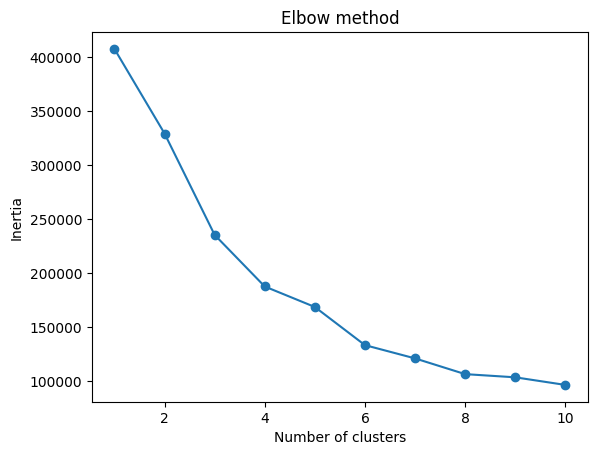

In [181]:
# get optimal number of clusters 
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.savefig('elbow_plot.png')
plt.show()

In [182]:
# Reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)
x = X_pca[:, 0]  # First principal component
y = X_pca[:, 1]  # Second principal component

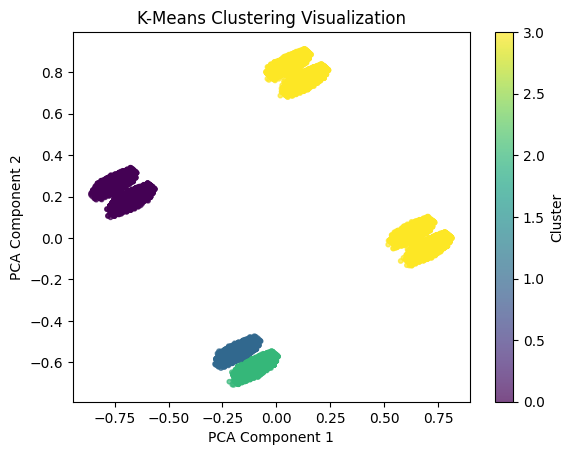

In [183]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(data)
data['Cluster'] = kmeans.fit_predict(data)  # Add cluster labels to the dataset

plt.scatter(x, y, c=kmeans.labels_, cmap='viridis', s=10, alpha=0.7)
plt.title('K-Means Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.savefig('cluster_plot.png')
plt.show()

In [184]:
# get cluster summary
cluster_summary = data.groupby('Cluster').mean()
print(cluster_summary)

              Age       BMI  Gender  Smoking_Status    Stress  \
Cluster                                                         
0        0.509498  0.245325     0.0        0.508696  1.000000   
1        0.546580  0.242517     0.0        0.486701  0.000000   
2        0.553714  0.230814     0.0        0.488460  0.000000   
3        0.545501  0.251459     1.0        0.541932  0.417346   

         Alcohol_Consumption  Physical_Activity  Family_History  
Cluster                                                          
0                   0.637333           0.232569        0.261270  
1                   0.643732           0.236472        1.000000  
2                   0.660190           0.238773        0.000000  
3                   0.736630           0.288865        0.238244  


## SOM Implementation